In [1]:
# import required libraries
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
from scipy.stats import norm
from termcolor import colored as cl 
import math
import pandas as pd
from dataclasses import dataclass
import itertools
from numba import jit, prange
import copy
import statistics

In [2]:
# simulation func for iterator-function
def simulation(process, start_state):
    state = start_state
    while True:
        yield state
        state = process.next_state(state)
    
    
# State class declaration
class State:
    pass

# process class
@dataclass
class OrnsteinOuhlenbeck:
    # implement internal class - State, storing process parameters and price
    @dataclass
    class State:
        price:   float = 1
    # process parameters :        
    kappa:   float = 1
    sigma:   float = 0.1
    theta:   float = 1
    dt:      float = 0.01
    sqrt_dt: float = 0.1

        
    def next_state(self, state: State) -> State:
        return OrnsteinOuhlenbeck.State(
            # price St+1 = St + theta * (kappa - St) * dt + sigma * dWt
            price = state.price + self.theta * (self.kappa - state.price)\
                * self.dt + self.sigma * np.random.normal(0, self.sqrt_dt)
        )
     
# trace generator function
def ou_price_traces(
        start_price: float = 1,
        kappa:       float = 1,
        sigma:       float = 0.1,
        theta:       float = 1,
        dt:          float = 0.01,
        time_steps:  int   = 100,
        num_traces:  int   = 1,
        random_state: int  = 0) -> np.ndarray:
    
    if random_state :
        np.random.seed(random_state)
        
    process = OrnsteinOuhlenbeck(
            kappa=kappa,
            sigma=sigma,
            theta=theta,
            dt=dt,
            sqrt_dt=np.sqrt(dt)
    )
    start_state = OrnsteinOuhlenbeck.State(price=start_price)
    return np.vstack([
            np.fromiter((s.price
                    for s in itertools.islice(simulation(process, start_state),
                                             time_steps)), float)
            for _ in range(num_traces)])

In [261]:
'''
    implementation for OU process (prices) environment

        action_space (available actions) as a dictionary, action_n - quantity of available actions
        state_space (possible states) as np.array of int, space_n - len(state_space)
        state, done = env.reset()
        state, reward, done, info = env.step(action)
    
    we define action_space as ['open_long', 'close_long', 'open_short', 'close_short'], action_n = 4
    state_space as stdev so it's [-4, -3, .. 0, 1, .. 4], state_n = 9
    reward as pnl by the next definition r_i = (close_i+2 - close_i) / close_i

'''
class OU_env:
    
    # by default if we don't send a process states as input we create new trace
    def __init__(self, 
                 random_state : int   = 0, 
                 states : np.ndarray  = None,
                 sma_window : int     = 50,
                 pnl_step : int       = 2
                ):
        '''
            initialize environment with provided prices trace or generate a random new
            then create states sequence as a feed for RL-agent with rewards for actions input
        '''
        
        self.random_state  = random_state   # to make available a repetition
        self.sma_window    = sma_window     # defines sma for algorithmic strategy
        
        # if prices trace was not provided -> generate a new one
        if states is None:
            self.states = pd.DataFrame( 
                ou_price_traces(
                    start_price=10, kappa=10, sigma=0.5, theta=1, dt=10**(-1), 
                    time_steps=150, num_traces=1, random_state=self.random_state).reshape(-1),
                columns = ['price']
            )
        else:
            self.states = pd.DataFrame(data=states, columns=['price'])
            
        # use prices to create states for the process
        self.states['sma']       = self.states.rolling(window=self.sma_window).mean()
        self.states['std']       = self.states['price'].rolling(window=self.sma_window).std()
        self.states['up_bb']     = self.states['sma'] + 2 * self.states['std']
        self.states['down_bb']   = self.states['sma'] - 2 * self.states['std']
        
        self.states['state']     = ( (self.states['price'] - self.states['sma']) / self.states['std'] ).round(0)
        self.states['position']  = 0
        
        self.step_number    = self.sma_window - 1   # indexer for pd.dataframe
        self.pnl_step       = pnl_step              # to calculate reward as pnl after pnl_step time steps
        
        # usable for RL parameters
        self.done           = False
        self.state          = self.states['state'][self.step_number].astype(int)
        self.action_space   = {'open_long' : 0, 'close_long' : 1, 'open_short' : 2, 'close_short' : 3}
        self.action_n       = len(self.action_space) 
        self.state_space    = np.arange(-4, 5, 1)
        self.state_n        = len(self.state_space)
        
    def reset(self, new_trace=False):
        if new_trace:
            self.step_number    = self.sma_window - 1
            self.done           = False
            self.states = pd.DataFrame( 
                ou_price_traces(
                    start_price=10, kappa=10, sigma=0.5, theta=1, dt=10**(-1), 
                    time_steps=150, num_traces=1, random_state=self.random_state).reshape(-1),
                columns = ['price']
            )
            
            # use prices to create states for the process
            self.states['sma']       = self.states.rolling(window=self.sma_window).mean()
            self.states['std']       = self.states['price'].rolling(window=self.sma_window).std()
            self.states['up_bb']     = self.states['sma'] + 2 * self.states['std']
            self.states['down_bb']   = self.states['sma'] - 2 * self.states['std']
            self.states['state']     = ( (self.states['price'] - self.states['sma']) / self.states['std'] ).round(0)
            self.states['position']  = 0
            
        else:
            self.step_number         = self.sma_window - 1
            self.done                = False
            self.state               = self.states['state'][self.step_number].astype(int)
            self.states['position']  = 0
        return self.state, self.done
    
    def step(self, action):
        '''
            on each step increment step_number(index for df)
            according to input action calculate and return 
            state, reward, done, info (='info')
        '''
        self.step_number += 1
        
        # since we define reward (pnl) via close_i+pnl_step, subtract pnl_step from the last step
        if ( self.step_number < len(self.states) - 1 - self.pnl_step):
            info   = 'info'
            self.state = self.states['state'][self.step_number].astype(int)
            
            # OK, let reward to be the next eq: r_i = sign(action) * ( close_(i+-pnl_step) - close_i ) / close_i
            
            # %2 == 0 means we open position !
            if (self.action_space.get(action) % 2) == 0:
                
                # set new position
                self.states.loc[self.step_number, 'position'] = 1 - self.action_space.get(action)
                
                # additional multiplier to encourage the agent to open position when there's a large deviation
                multiplier = abs(self.states['state'][self.step_number]) + 1
                
                # don't forget to correct signum according to provided action! (short = -1, long +1)
                reward = (self.states['price'][self.step_number + self.pnl_step] - self.states['price'][self.step_number])\
                            / self.states['price'][self.step_number] * self.states['position'][self.step_number] * multiplier
                
                
            # close position => define reward as : sign(action) * ( close_(i) - close_(i-pnl_step) ) / close_(i-pnl_step)
            else:
                
                # set new position
                self.states.loc[self.step_number, 'position'] = 0
                
                # the same logic to encourage to close position when the price is near SMA
                multiplier = 2 - abs(self.states['state'][self.step_number])
                
                # don't forget to correct signum according to provided action! (short = -1, long +1)
                reward = (self.states['price'][self.step_number] - self.states['price'][self.step_number - self.pnl_step])\
                            / self.states['price'][self.step_number - self.pnl_step] * self.states['position'][self.step_number] * multiplier

        else:
            self.done = True
            self.state = 0
            reward = 0
            info   = 'info' 
        return self.state, reward, self.done, info
    
    def vector_backtest(self, cost_bps=0, render=True):
        # calculate trades as change in curr position
        trades = np.concatenate([[0], self.states['position'].diff()[1:]])
        
        # market value is product of curr price on corr trade
        market_value = trades * self.states['price']
        
        # difference cash is -market_value since our cash = 0 
        # so position > 0 => (long) => -cash (<0) ; <0 => short we have +cash (>0)
        dcash  = -market_value
        
        # cash is time-dependant vector between cash difference and costs on transactions
        cash   = np.cumsum(dcash) - np.cumsum(abs(market_value) * cost_bps)
        
        # market to market - result 
        m2m    = cash + self.states['position'] * self.states['price']
        
        
        if render:
            plt.figure(figsize=(15,8))
            plt.plot(market_value[self.sma_window:])
            plt.grid()
            plt.ylabel('Market value')
            plt.title('Market value')
            plt.show()
            
            plt.figure(figsize=(15,8))
            plt.plot(cash[self.sma_window:])
            plt.grid()
            plt.ylabel('Cash')
            plt.title('Cash')
            plt.show()
        
            plt.figure(figsize=(15,8))
            plt.plot(m2m[self.sma_window:])
            plt.grid()
            plt.ylabel('Profit')
            plt.title('Market to market')
            plt.show()
        
        return m2m[self.sma_window:], self.states['position'][self.sma_window:]
        
    def render(self):
        '''
            makes two plots with original process with bolinger bands
            and discretized with price process states according to bolinger strategy
        '''
        plt.figure(figsize=(15,7))
        plt.plot(self.states['price'][self.sma_window:], c='skyblue', alpha=1, label='underlying price')
        plt.plot(self.states['sma'][self.sma_window:], c='#C1C1C1', alpha=1, label=f'sma {self.sma_window}')
        plt.plot(self.states['up_bb'][self.sma_window:], linestyle='--', alpha=0.5, linewidth=1, c='black')
        plt.plot(self.states['down_bb'][self.sma_window:], linestyle='--', alpha=0.5, linewidth=1, c='black')
        plt.xlabel('time steps')
        plt.ylabel('price')
        plt.xlim((self.sma_window-1, len(self.states)))
        plt.legend()
        plt.show()
        
        plt.figure(figsize=(15,7))
        plt.scatter(self.states.index, self.states['state'], s=15, c='blue', alpha=0.75, label='state')
        plt.xlabel('time steps')
        plt.ylabel('state (as std)')
        plt.xlim((self.sma_window-1, len(self.states)))
        plt.yticks(self.state_space)
        plt.legend()
        plt.show()

In [255]:
# implemet agent with q-values function
class RL_agent:
    def __init__(self, states, actions):
        '''
            initialize RL agent with possible environment states it acts to
            with possible actions to interact
            create q_function as a 2D-dict with states -> actions -> q_value 
        '''
        self.actions    = actions
        self.states     = states
        self.q_function = {
            state : {action : 0 
                for action in self.actions}
            for state in self.states
        }
        self.counter    = copy.deepcopy(self.q_function)

    def get_epsilon_greedy_action(self, q_values, epsilon : float):
        '''
            using epsilon greedy policy choose the best action according to q_function
            return action
        '''
        policy = np.ones(len(self.actions)) * epsilon / len(self.actions)
        max_action = np.argmax(q_values)
        policy[max_action] += 1 - epsilon
        return np.random.choice(self.actions, p=policy)
    
# class-free function back_test
def back_test(agent, env, cost_bps=0, render=True):
    epsilon = 0
    state = env.reset()[0]
    total_rews = 0
    for _ in range(len(env.states)):
        action = agent.get_epsilon_greedy_action(list(agent.q_function[state].values()), epsilon)
        state, reward, done, info = env.step(action)
        total_rews += reward
        if done:
            break
    return env.vector_backtest(cost_bps, render)

In [3]:
class MonteCarlo:
    def __init__(self, env, agent, episode_n, trajectory_len : int, gamma : float):
        self.env            = env
        self.agent          = agent
        self.episode_n      = episode_n
        self.trajectory_len = trajectory_len
        self.gamma          = gamma
        
    def simulate(self):
        self.total_rewards = []
        epsilon : float = 1
        state_n : int   = len(self.agent.states)
        action_n : int  = len(self.agent.actions)
        actions         = self.agent.actions
        
        for episode in range(self.episode_n):
            epsilon = 1 / (episode + 1)
            trajectory = {'states' : [], 'actions' : [], 'rewards' : []}
            
            state = self.env.reset()[0]
            for _ in range(self.trajectory_len):
                trajectory['states'].append(state)
                
                action = self.agent.get_epsilon_greedy_action(list(self.agent.q_function[state].values()), epsilon)
                trajectory['actions'].append(action)
                
                state, reward, done, info = self.env.step(action)
                trajectory['rewards'].append(reward)
                
                if done:
                    break
            
            self.total_rewards.append(sum(trajectory['rewards']))
            realised_trajectory_len = len(trajectory['rewards'])
            
            returns = np.zeros(realised_trajectory_len + 1)
            for t in range(realised_trajectory_len - 1, -1, -1):
                returns[t] = trajectory['rewards'][t] + self.gamma * returns[t + 1]
            
            for t in range(realised_trajectory_len):
                state  = trajectory['states'][t]
                action = trajectory['actions'][t]
                self.agent.q_function[state][action] +=\
                    ( returns[t] - self.agent.q_function[state][action] ) / (1 + self.agent.counter[state][action])
                self.agent.counter[state][action] += 1
                
        return self.total_rewards
    
    def get_performance(self, validation_n : int = 10):
        epsilon = 0.05 # add a little stochastic
        performance_rewards = []
        for i in range(validation_n):
            trajectory = {'states' : [], 'actions' : [], 'rewards' : []}
            state = self.env.reset()[0]
                
            for _ in range(self.trajectory_len):
                trajectory['states'].append(state)
                action = self.agent.get_epsilon_greedy_action(list(self.agent.q_function[state].values()), epsilon)
                trajectory['actions'].append(action)

                state, reward, done, info = self.env.step(action)
                trajectory['rewards'].append(reward)
                    
                if done:
                    break
        
        performance_rewards.append(sum(trajectory['rewards']))
        return trajectory, performance_rewards

In [4]:
class SARSA:
    def __init__(self, env, agent, episode_n, trajectory_len : int, gamma : float, alpha : float):
        self.env            = env
        self.agent          = agent
        self.episode_n      = episode_n
        self.trajectory_len = trajectory_len
        self.gamma          = gamma
        self.alpha          = alpha
        
    def simulate(self):
        self.total_rewards = np.zeros(self.episode_n)
        epsilon : float = 1
        state_n : int   = len(self.agent.states)
        action_n : int  = len(self.agent.actions)
        actions         = self.agent.actions
        
        for episode in range(self.episode_n):
            epsilon = 1 / (episode + 1)
            
            state = self.env.reset()[0]
            action = self.agent.get_epsilon_greedy_action(list(self.agent.q_function[state].values()), epsilon)
            
            for _ in range(self.trajectory_len):
                
                next_state, reward, done, info = self.env.step(action)
                next_action = self.agent.get_epsilon_greedy_action(list(self.agent.q_function[next_state].values()), epsilon)
                
                self.agent.q_function[state][action] +=\
                    self.alpha * (reward + self.gamma * self.agent.q_function[next_state][next_action]\
                                 - self.agent.q_function[state][action])
                state  = next_state
                action = next_action 
                self.total_rewards[episode] += reward
                
                if done:
                    break
                
        return self.total_rewards
    
    def get_performance(self, validation_n : int = 10):
        epsilon = 0.05 # add a little stochastic
        performance_rewards = []
        for i in range(validation_n):
            trajectory = {'states' : [], 'actions' : [], 'rewards' : []}
            state = self.env.reset()[0]
                
            for _ in range(self.trajectory_len):
                trajectory['states'].append(state)
                action = self.agent.get_epsilon_greedy_action(list(self.agent.q_function[state].values()), epsilon)
                trajectory['actions'].append(action)

                state, reward, done, info = self.env.step(action)
                trajectory['rewards'].append(reward)
                    
                if done:
                    break
        
        performance_rewards.append(sum(trajectory['rewards']))
        return trajectory, performance_rewards

In [5]:
class Q_learning:
    def __init__(self, env, agent, episode_n, trajectory_len : int, gamma : float, alpha : float):
        self.env            = env
        self.agent          = agent
        self.episode_n      = episode_n
        self.trajectory_len = trajectory_len
        self.gamma          = gamma
        self.alpha          = alpha
        
    def simulate(self):
        self.total_rewards = np.zeros(self.episode_n)
        epsilon : float = 1
        state_n : int   = len(self.agent.states)
        action_n : int  = len(self.agent.actions)
        actions         = self.agent.actions
        
        for episode in range(self.episode_n):
            epsilon = 1 / (episode + 1)
            
            state = self.env.reset()[0]
            action = self.agent.get_epsilon_greedy_action(list(self.agent.q_function[state].values()), epsilon)
            
            for _ in range(self.trajectory_len):
                
                next_state, reward, done, info = self.env.step(action)
                
                q_max = max(list(self.agent.q_function[next_state].values()))
                self.agent.q_function[state][action] +=\
                    self.alpha * (reward + self.gamma * q_max\
                                 - self.agent.q_function[state][action])
                action = self.agent.get_epsilon_greedy_action(list(self.agent.q_function[next_state].values()), epsilon)
                state  = next_state
                self.total_rewards[episode] += reward
                
                if done:
                    break
                
        return self.total_rewards
    
    def get_performance(self, validation_n : int = 10):
        '''
            use agent q_table to run through env and get performance reward
            return trajectory dict, performance array (list)
        '''
        epsilon = 0.05 # add a little stochastic
        performance_rewards = []
        for i in range(validation_n):
            trajectory = {'states' : [], 'actions' : [], 'rewards' : []}
            state = self.env.reset()[0]
                
            for _ in range(self.trajectory_len):
                trajectory['states'].append(state)
                action = self.agent.get_epsilon_greedy_action(list(self.agent.q_function[state].values()), epsilon)
                trajectory['actions'].append(action)

                state, reward, done, info = self.env.step(action)
                trajectory['rewards'].append(reward)
                    
                if done:
                    break
        
            performance_rewards.append(sum(trajectory['rewards']))
        return trajectory, performance_rewards

In [6]:
class Eligibility_trace_SARSA:
    def __init__(self, env, agent, episode_n, trajectory_len : int, gamma : float, alpha : float, beta : float):
        self.env            = env
        self.agent          = agent
        self.episode_n      = episode_n
        self.trajectory_len = trajectory_len
        self.gamma          = gamma
        self.alpha          = alpha
        self.beta           = beta
        
    def simulate(self):
        self.total_rewards = np.zeros(self.episode_n)
        epsilon : float = 1
        state_n : int   = len(self.agent.states)
        action_n : int  = len(self.agent.actions)
        actions         = self.agent.actions
        
        for episode in range(self.episode_n):
            
            state_action_counter = { 
                state : {action : 0 
                         for action in self.agent.actions}
                    for state in self.agent.states 
            }
            
            epsilon = 1 / (episode + 1)
            
            state = self.env.reset()[0]
            action = self.agent.get_epsilon_greedy_action(list(self.agent.q_function[state].values()), epsilon)
            
            for _ in range(self.trajectory_len):
                
                # accumulating traces
                state_action_counter[state][action] += 1 
                
                # dutch traces
                #state_action_counter[state][action] +=\
                #    (1 - self.alpha) * state_action_counter[state][action] + 1 
                
                # replacing traces => simple q-learning
                #state_action_counter[state][action] = 1
                
                next_state, reward, done, info = self.env.step(action)
                next_action = self.agent.get_epsilon_greedy_action(
                    list(self.agent.q_function[next_state].values()), epsilon)
                
                delta = reward + self.gamma * self.agent.q_function[next_state][next_action]\
                    - self.agent.q_function[state][action]
               
                for e_state in self.agent.states:
                    for e_action in self.agent.actions:
                        self.agent.q_function[e_state][e_action] +=\
                            self.alpha * delta * state_action_counter[e_state][e_action]
                        state_action_counter[e_state][e_action] *= self.gamma * self.beta

                state  = next_state
                action = next_action
                
                self.total_rewards[episode] += reward
                
                if done:
                    break
                
        return self.total_rewards
    
    def get_performance(self, validation_n : int = 10):
        '''
            use agent q_table to run through env and get performance reward
            return trajectory dict, performance array (list)
        '''
        epsilon = 0.05 # add a little stochastic
        performance_rewards = []
        for i in range(validation_n):
            trajectory = {'states' : [], 'actions' : [], 'rewards' : []}
            state = self.env.reset()[0]
                
            for _ in range(self.trajectory_len):
                trajectory['states'].append(state)
                action = self.agent.get_epsilon_greedy_action(list(self.agent.q_function[state].values()), epsilon)
                trajectory['actions'].append(action)

                state, reward, done, info = self.env.step(action)
                trajectory['rewards'].append(reward)
                    
                if done:
                    break
        
            performance_rewards.append(sum(trajectory['rewards']))
        return trajectory, performance_rewards

In [7]:
class Eligibility_trace_Q:
    def __init__(self, env, agent, episode_n, trajectory_len : int, gamma : float, alpha : float, beta : float):
        self.env            = env
        self.agent          = agent
        self.episode_n      = episode_n
        self.trajectory_len = trajectory_len
        self.gamma          = gamma
        self.alpha          = alpha
        self.beta           = beta
        
    def simulate(self):
        self.total_rewards = np.zeros(self.episode_n)
        epsilon : float = 1
        state_n : int   = len(self.agent.states)
        action_n : int  = len(self.agent.actions)
        actions         = self.agent.actions
        
        for episode in range(self.episode_n):
            
            state_action_counter = { 
                state : {action : 0 
                         for action in self.agent.actions}
                    for state in self.agent.states 
            }
            
            epsilon = 1 / (episode + 1)
            
            state = self.env.reset()[0]
            action = self.agent.get_epsilon_greedy_action(list(self.agent.q_function[state].values()), epsilon)
            
            for _ in range(self.trajectory_len):
                
                # accumulating traces
                state_action_counter[state][action] += 1 
                
                # dutch traces
                #state_action_counter[state][action] += (1 - self.alpha) * state_action_counter[state] + 1 
                
                # replacing traces => simple q-learning
                #state_action_counter[state][action] = 1
                
                next_state, reward, done, info = self.env.step(action)
                next_action = self.agent.get_epsilon_greedy_action(
                    list(self.agent.q_function[next_state].values()), epsilon)
                
                q_max = max(list(self.agent.q_function[next_state].values()))
                delta = reward + self.gamma * q_max - self.agent.q_function[state][action]
                
                for e_state in self.agent.states:
                    for e_action in self.agent.actions:
                        self.agent.q_function[e_state][e_action] +=\
                            self.alpha * delta * state_action_counter[e_state][e_action]
                        
                        if q_max == self.agent.q_function[next_state][next_action]:
                            state_action_counter[e_state][e_action] *= self.gamma * self.beta
                        else:
                            state_action_counter[e_state][e_action] = 0

                state  = next_state
                action = next_action
                
                self.total_rewards[episode] += reward
                
                if done:
                    break
                
        return self.total_rewards
    
    def get_performance(self, validation_n : int = 10):
        '''
            use agent q_table to run through env and get performance reward
            return trajectory dict, performance array (list)
        '''
        epsilon = 0.05 # add a little stochastic
        performance_rewards = []
        for i in range(validation_n):
            trajectory = {'states' : [], 'actions' : [], 'rewards' : []}
            state = self.env.reset()[0]
                
            for _ in range(self.trajectory_len):
                trajectory['states'].append(state)
                action = self.agent.get_epsilon_greedy_action(list(self.agent.q_function[state].values()), epsilon)
                trajectory['actions'].append(action)

                state, reward, done, info = self.env.step(action)
                trajectory['rewards'].append(reward)
                    
                if done:
                    break
        
            performance_rewards.append(sum(trajectory['rewards']))
        return trajectory, performance_rewards

In [8]:
class Dyna_Q:
    def __init__(self, env, agent, episode_n, trajectory_len : int, 
                 gamma : float, alpha : float, planning_n : int):
        self.env            = env
        self.agent          = agent
        self.episode_n      = episode_n
        self.trajectory_len = trajectory_len
        self.gamma          = gamma
        self.alpha          = alpha
        self.planning_n     = planning_n
        self.model          = { state : { action : [0, 0]
                                    for action in self.agent.actions }
                                for state in self.agent.states }
        
    def simulate(self):
        self.total_rewards = np.zeros(self.episode_n)
        epsilon : float = 1
        state_n : int   = len(self.agent.states)
        action_n : int  = len(self.agent.actions)
        actions         = self.agent.actions
        
        for episode in range(self.episode_n):
            epsilon = 1 / (episode + 1)
            
            # execute first step in env and get state, action pair
            state = self.env.reset()[0]
            action = self.agent.get_epsilon_greedy_action(list(self.agent.q_function[state].values()), epsilon)
            
            for _ in range(self.trajectory_len):
                
                # execute next step using action
                next_state, reward, done, info = self.env.step(action)
                
                # q-learning
                q_max = max(list(self.agent.q_function[next_state].values()))
                self.agent.q_function[state][action] +=\
                    self.alpha * (reward + self.gamma * q_max\
                                 - self.agent.q_function[state][action])
                
                # assign to model[state][action] reward and next state from env interaction
                self.model[state][action][0] += reward
                self.model[state][action][1]  = next_state
                
                # planning process
                for _ in range(self.planning_n):
                    
                    # take random sample of states and actions
                    random_state  = np.random.choice(self.agent.states)
                    random_action = np.random.choice(self.agent.actions)
                    
                    # take modeled state, reward from model via sampled state, action
                    model_reward, model_state = self.model[random_state][random_action]
                    
                    # take max of Q for modeled state
                    q_max = max(list(self.agent.q_function[model_state].values()))
                    
                    # update q-function for sampled state, action
                    self.agent.q_function[random_state][random_action] +=\
                        self.alpha * (model_reward + self.gamma * q_max\
                                 - self.agent.q_function[random_state][random_action])
                
                # take the next action, reassign current state
                action = self.agent.get_epsilon_greedy_action(list(self.agent.q_function[next_state].values()), epsilon)
                state  = next_state
                
                self.total_rewards[episode] += reward
                
                if done:
                    break
                
        return self.total_rewards
    
    def get_performance(self, validation_n : int = 10):
        '''
            use agent q_table to run through env and get performance reward
            return trajectory dict, performance array (list)
        '''
        epsilon = 0.05 # add a little stochastic
        performance_rewards = []
        for i in range(validation_n):
            trajectory = {'states' : [], 'actions' : [], 'rewards' : []}
            state = self.env.reset()[0]
                
            for _ in range(self.trajectory_len):
                trajectory['states'].append(state)
                action = self.agent.get_epsilon_greedy_action(list(self.agent.q_function[state].values()), epsilon)
                trajectory['actions'].append(action)

                state, reward, done, info = self.env.step(action)
                trajectory['rewards'].append(reward)
                    
                if done:
                    break
        
            performance_rewards.append(sum(trajectory['rewards']))
        return trajectory, performance_rewards

In [9]:
'''
    implementation for OU process (prices) environment

        action_space (available actions) as a dictionary, action_n - quantity of available actions
        state_space (possible states) as np.array of int, space_n - len(state_space)
        state, done = env.reset()
        state, reward, done, info = env.step(action)
    
    we define action_space as ['open_long', 'close_long', 'open_short', 'close_short'], action_n = 4
    state_space as stdev so it's [-4, -3, .. 0, 1, .. 4], state_n = 9
    reward as pnl by the next definition r_i = (close_i+2 - close_i) / close_i

'''
class OU_env:
    
    # by default if we don't send a process states as input we create new trace
    def __init__(self, 
                 random_state : int   = 0, 
                 states : np.ndarray  = None,
                 sma_window : int     = 50,
                 pnl_step : int       = 2,
                 risk_avertive : bool = True
                ):
        '''
            initialize environment with provided prices trace or generate a random new
            then create states sequence as a feed for RL-agent with rewards for actions input
        '''
        
        self.risk_avertive = risk_avertive  # to define state format
        self.random_state  = random_state   # to make available a repetition
        self.sma_window    = sma_window     # defines sma for algorithmic strategy
        
        # if prices trace was not provided -> generate a new one
        if states is None:
            self.states = pd.DataFrame( 
                ou_price_traces(
                    start_price=10, kappa=10, sigma=0.5, theta=1, dt=10**(-1), 
                    time_steps=150, num_traces=1, random_state=self.random_state).reshape(-1),
                columns = ['price']
            )
        else:
            self.states = pd.DataFrame(data=states, columns=['price'])
            
        # use prices to create states for the process
        self.states['sma']       = self.states.rolling(window=self.sma_window).mean()
        self.states['std']       = self.states['price'].rolling(window=self.sma_window).std()
        self.states['up_bb']     = self.states['sma'] + 2 * self.states['std']
        self.states['down_bb']   = self.states['sma'] - 2 * self.states['std']
        
        self.states['state']     = ( (self.states['price'] - self.states['sma']) / self.states['std'] ).fillna(0).astype(int)
        self.states['position']  = 0
        
        self.step_number    = self.sma_window - 1   # indexer for pd.dataframe
        self.pnl_step       = pnl_step              # to calculate reward as pnl after pnl_step time steps
        
        # usable for RL parameters
        self.done           = False
        self.state          = self.states['state'][self.step_number]
        self.action_space   = {'open_long' : 0, 'close_long' : 1, 'open_short' : 2, 'close_short' : 3}
        self.action_n       = len(self.action_space) 
        self.state_space    = np.arange(-4, 5, 1)
        self.state_n        = len(self.state_space)
        
    def reset(self, new_trace=False):
        if new_trace:
            self.step_number    = self.sma_window - 1
            self.done           = False
            self.states = pd.DataFrame( 
                ou_price_traces(
                    start_price=10, kappa=10, sigma=0.5, theta=1, dt=10**(-1), 
                    time_steps=150, num_traces=1, random_state=self.random_state).reshape(-1),
                columns = ['price']
            )
            
            # use prices to create states for the process
            self.states['sma']       = self.states.rolling(window=self.sma_window).mean()
            self.states['std']       = self.states['price'].rolling(window=self.sma_window).std()
            self.states['up_bb']     = self.states['sma'] + 2 * self.states['std']
            self.states['down_bb']   = self.states['sma'] - 2 * self.states['std']
            self.states['state']     = ( (self.states['price'] - self.states['sma']) / self.states['std'] ).fillna(0).astype(int)
            self.states['position']  = 0
            
        else:
            self.step_number         = self.sma_window - 1
            self.done                = False
            self.state               = self.states['state'][self.step_number].astype(int)
            self.states['position']  = 0
            
        if self.risk_avertive:
            return (self.state, self.states['position'][self.step_number]), self.done
        else:          
            return self.state, self.done
    
    def step(self, action):
        '''
            on each step increment step_number(index for df)
            according to input action calculate and return 
            state, reward, done, info (='info')
        '''
        if self.step_number >= (len(self.states) - 1 - self.pnl_step) :
            self.done = True
            self.state = 0
            reward = 0
            info   = 'info'
        
        # since we define reward (pnl) via close_i+pnl_step, subtract pnl_step from the last step
        else :
            self.step_number += 1
            info   = 'info'
            self.state = self.states['state'][self.step_number]
            
            # OK, let reward to be the next eq: r_i = sign(action) * ( close_(i+-pnl_step) - close_i ) / close_i
            
            # %2 == 0 means we open position !
            if (self.action_space.get(action) % 2) == 0:
                
                if ( self.states.loc[self.step_number - 1, 'position'] * (1 - self.action_space.get(action)) ) < 0 :
                    # change position
                    self.states.loc[self.step_number, 'position'] = 1 - self.action_space.get(action)
                else:
                    # increase position
                    self.states.loc[self.step_number, 'position'] =\
                        self.states.loc[self.step_number - 1, 'position'] + 1 - self.action_space.get(action)
                
                # additional multiplier to encourage the agent to open position when there's a large deviation
                multiplier = abs(self.states['state'][self.step_number]) + 1
                
                # don't forget to correct signum according to provided action! (short = -1, long +1)
                reward = (self.states['price'][self.step_number + self.pnl_step] - self.states['price'][self.step_number])\
                            / self.states['price'][self.step_number] * self.states['position'][self.step_number] * multiplier
                
            # close position => define reward as : sign(action) * ( close_(i) - close_(i-pnl_step) ) / close_(i-pnl_step)
            else:
                
                # set new position
                self.states.loc[self.step_number, 'position'] = 0
                
                # the same logic to encourage to close position when the price is near SMA
                multiplier = 2 - abs(self.states['state'][self.step_number])
                
                # don't forget to correct signum according to provided action! (short = -1, long +1)
                reward = (self.states['price'][self.step_number] - self.states['price'][self.step_number - self.pnl_step])\
                            / self.states['price'][self.step_number - self.pnl_step] * self.states['position'][self.step_number] * multiplier

        if self.risk_avertive:
            return (self.state, self.states['position'][self.step_number]), reward, self.done, info
        else:
            return self.state, reward, self.done, info
        
    # use positioned env trace to calc pnl
    def vector_backtest(self, cost_bps=0, render=True):
        # calculate trades as change in curr position
        trades = np.concatenate([[0], self.states['position'].diff()[1:]])
        
        # market value is product of curr price on corr trade
        market_value = trades * self.states['price']
        
        # difference cash is -market_value since our cash = 0 
        # so position > 0 => (long) => -cash (<0) ; <0 => short we have +cash (>0)
        dcash  = -market_value
        
        # cash is time-dependant vector between cash difference and costs on transactions
        cash   = np.cumsum(dcash) - np.cumsum(abs(market_value) * cost_bps)
        
        # market to market - result 
        m2m    = cash + self.states['position'] * self.states['price']
        
        if render:
            plt.figure(figsize=(15,8))
            plt.plot(market_value[self.sma_window:])
            plt.grid()
            plt.ylabel('Market value')
            plt.title('Market value')
            plt.show()
            
            plt.figure(figsize=(15,8))
            plt.plot(cash[self.sma_window:])
            plt.grid()
            plt.ylabel('Cash')
            plt.title('Cash')
            plt.show()
        
            plt.figure(figsize=(15,8))
            plt.plot(m2m[self.sma_window:])
            plt.grid()
            plt.ylabel('Profit')
            plt.title('Market to market')
            plt.show()
        
        return m2m[self.sma_window:], self.states['position'][self.sma_window:]
        
    def render(self):
        '''
            makes two plots with original process with bolinger bands
            and discretized with price process states according to bolinger strategy
        '''
        plt.figure(figsize=(15,7))
        plt.plot(self.states['price'][self.sma_window:], c='skyblue', alpha=1, label='underlying price')
        plt.plot(self.states['sma'][self.sma_window:], c='#C1C1C1', alpha=1, label=f'sma {self.sma_window}')
        plt.plot(self.states['up_bb'][self.sma_window:], linestyle='--', alpha=0.5, linewidth=1, c='black')
        plt.plot(self.states['down_bb'][self.sma_window:], linestyle='--', alpha=0.5, linewidth=1, c='black')
        plt.xlabel('time steps')
        plt.ylabel('price')
        plt.xlim((self.sma_window-1, len(self.states)))
        plt.legend()
        plt.show()
        
        plt.figure(figsize=(15,7))
        plt.scatter(self.states.index, self.states['state'], s=15, c='blue', alpha=0.75, label='state')
        plt.xlabel('time steps')
        plt.ylabel('state (as std)')
        plt.xlim((self.sma_window-1, len(self.states)))
        plt.yticks(self.state_space)
        plt.legend()
        plt.show()

In [14]:
# implement agent with q-values function
class RL_agent:
    def __init__(self, states, actions, risk_avertive = True, max_pos : int = 1):
        '''
            initialize RL agent with possible environment states it acts to
            with possible actions to interact
            create q_function as a 2D-dict with states -> actions -> q_value 
        '''
        self.risk_avertive = risk_avertive
        self.max_pos       = abs(max_pos)
        self.actions       = actions
        
        if self.risk_avertive:
            self.states        = [ (state, pos) for pos in np.arange(-max_pos, max_pos + 1)
                                for state in states ]
            self.q_function = {
                    (state, pos) : { action : 0
                        for action in self.actions}
                    for pos in np.arange(-max_pos, max_pos + 1)
                for state in states
            }
            
            for state, pos in self.states:
                for action in self.actions:
                    if (pos <= -max_pos and abs(self.actions.get(action) - 1.5) > 1)\
                        or (pos >= max_pos and abs(self.actions.get(action) - 1.5) < 1)\
                        or (abs(pos) - max_pos == -1 and pos != 0)\
                        or (pos == 0 and abs(self.actions.get(action) - 1) == 1):
                            self.q_function[(state, pos)][action] = 0
                    else:
                        self.q_function[(state, pos)][action] = float('-inf')
                    if (pos < 0 and action == 'close_long') or (pos > 0 and action == 'close_short'):
                        self.q_function[(state, pos)][action] = float('-inf')
        else:
            self.states        = [ state for state in states ]
            self.q_function = {
                    state : { action : 0 for action in self.actions}
                for state in states
            }
                    
        self.counter    = copy.deepcopy(self.q_function)

    def get_epsilon_greedy_action(self, q_values, epsilon : float):
        '''
            using epsilon greedy policy choose the best action according to q_function
            return action
        '''
        valid_q_values = np.array(np.asarray(q_values) > -10 ** 10)
        policy = np.ones(len(q_values)) * valid_q_values * epsilon / valid_q_values.sum()
        max_action = np.argmax(q_values)
        policy[max_action] += 1 - epsilon
        return np.random.choice(self.actions, p=policy)
    
# class-free function back_test
def back_test(agent, env, cost_bps=0, render=True):
    epsilon = 0
    state = env.reset()[0]
    total_rews = 0
    for _ in range(len(env.states)):
        action = agent.get_epsilon_greedy_action(list(agent.q_function[state].values()), epsilon)
        state, reward, done, info = env.step(action)
        total_rews += reward
        if done:
            break
    return env.vector_backtest(cost_bps, render)

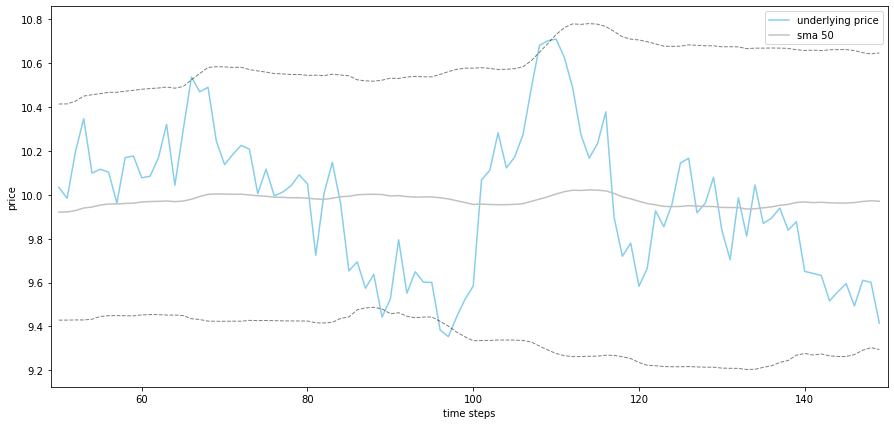

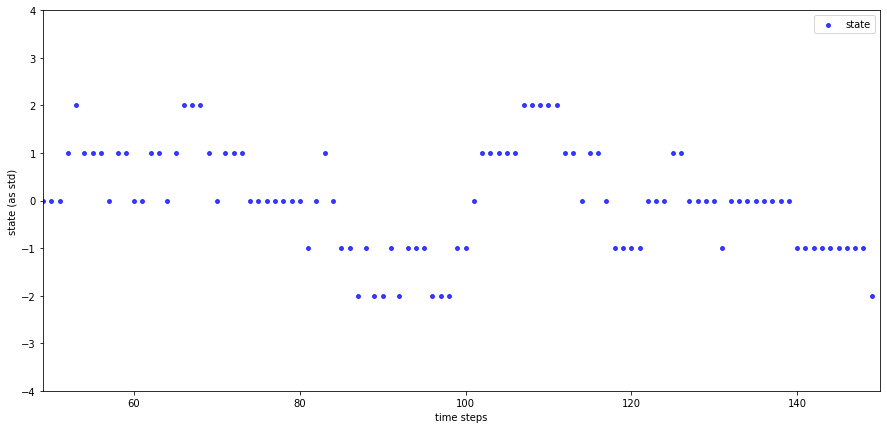

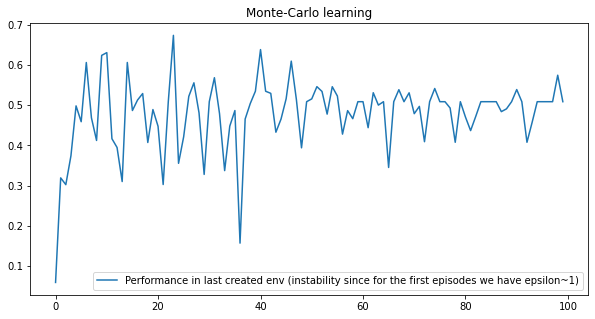

For trained agent for given env the best policy according his q-function
state => -4, action => no cases for this state
state => -3, action => open_long
state => -2, action => close_long
state => -1, action => open_long
state => 0, action => open_long
state => 1, action => open_short
state => 2, action => open_short
state => 3, action => open_short
state => 4, action => no cases for this state


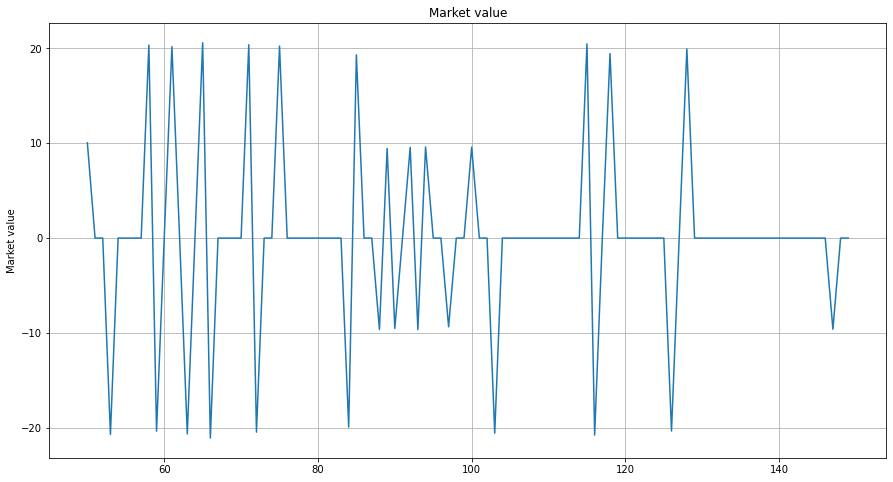

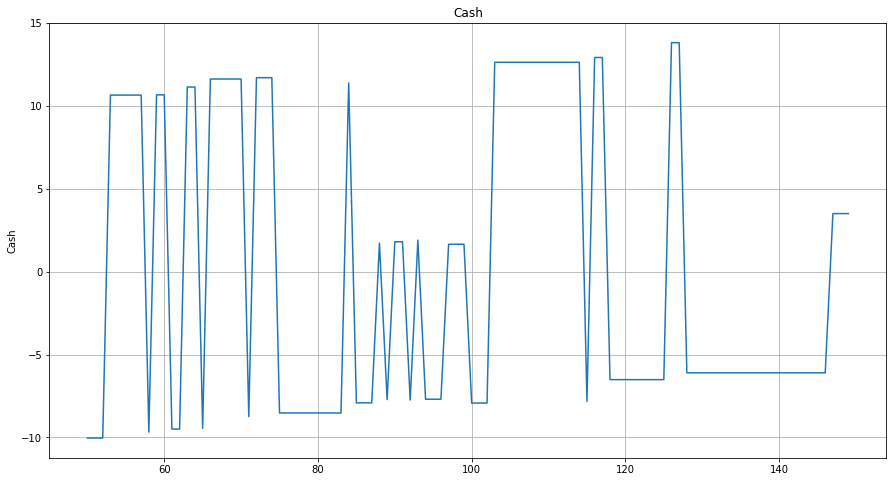

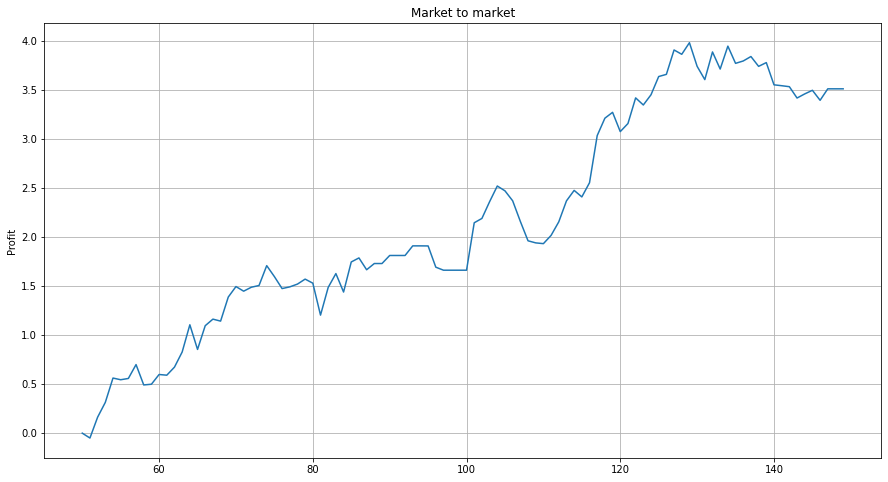

CPU times: total: 1min 21s
Wall time: 1min 23s


{-4: {'open_long': 0, 'close_long': 0, 'open_short': 0, 'close_short': 0},
 -3: {'open_long': 0.13973140239659093,
  'close_long': 0.05131104014914041,
  'open_short': 0.03559842546512607,
  'close_short': 0.058338781152697736},
 -2: {'open_long': 0.06208259416496623,
  'close_long': 0.08935262046285551,
  'open_short': 0.029076464531344152,
  'close_short': 0.03339306872136382},
 -1: {'open_long': 0.08205533140257062,
  'close_long': 0.03819413532180449,
  'open_short': 0.023042412852351372,
  'close_short': 0.02635341641853931},
 0: {'open_long': 0.06281173774485656,
  'close_long': 0.0443813593045982,
  'open_short': 0.04731630157324309,
  'close_short': 0.04449879571073195},
 1: {'open_long': 0.03799588638039441,
  'close_long': 0.05621664748094136,
  'open_short': 0.08390695650651693,
  'close_short': 0.05569968522299442},
 2: {'open_long': 0.03919978590106502,
  'close_long': 0.05916664511817619,
  'open_short': 0.11008785710732728,
  'close_short': 0.06510560555139452},
 3: {'op

In [280]:
%%time

'''
    here is an example of typical interface for agent, env, rl-algorithm
'''

risk_avertive = False
# create env object
env = OU_env(sma_window=50, pnl_step=4, risk_avertive=risk_avertive)

# set parameters for learning
episode_n = 100
trajectory_len = len(env.states)
gamma = 0.9
alpha = 0.7
beta = 0.25


# create RL-agent object ( state for env and actions as inputs )
agent = RL_agent(env.state_space, list(env.action_space.keys()), risk_avertive=risk_avertive)

# create RL-algorithm object ( => env, agent, RL-params* )
rl_MC      = MonteCarlo(env, agent, episode_n, trajectory_len, gamma)
rl_SARSA   = SARSA(env, agent, episode_n, trajectory_len, gamma, alpha)
rl_Q       = Q_learning(env, agent, episode_n, trajectory_len, gamma, alpha)
rl_ET_S    = Eligibility_trace_SARSA(env, agent, episode_n, trajectory_len, gamma, alpha, beta)
rl_ET_Q    = Eligibility_trace_Q(env, agent, episode_n, trajectory_len, gamma, alpha, beta)

# start learning => return total rewards during learning epochs
for _ in range(20): # multiple learning for existed agent so he learns in diff envs
    env     = OU_env(sma_window=50, pnl_step=2)
    rl_MC   = MonteCarlo(env, agent, episode_n, trajectory_len, gamma)
    rews_mc = rl_MC.simulate()

# or we can learn the existed agent using other RL-alogorithms:
# rews_mc    = rl_MC.simulate()
# rews_sarsa = rl_SARSA.simulate()
# rews_q_l   = rl_Q.simulate()
# rews_elig  = rl_ET.simulate()

# plot total rewards
env.render()
plt.figure(figsize=(10,5))
plt.plot(rews_mc, label=f'Performance in last created env (instability since for the first episodes we have epsilon~1)')
plt.title('Monte-Carlo learning')
plt.legend()
plt.show()

# show the policy
print('For trained agent for given env the best policy according his q-function')
for state in agent.states:
    if abs(np.mean(list(agent.q_function[state].values()))) > 1e-5:
        print(f'state => {state}, action =>',
            f'{agent.get_epsilon_greedy_action(list(agent.q_function[state].values()), 0)}')
    else: 
        print(f'state => {state}, action => no cases for this state')
        
m2m, pos = back_test(agent, env, cost_bps=0, render=True)
agent.q_function

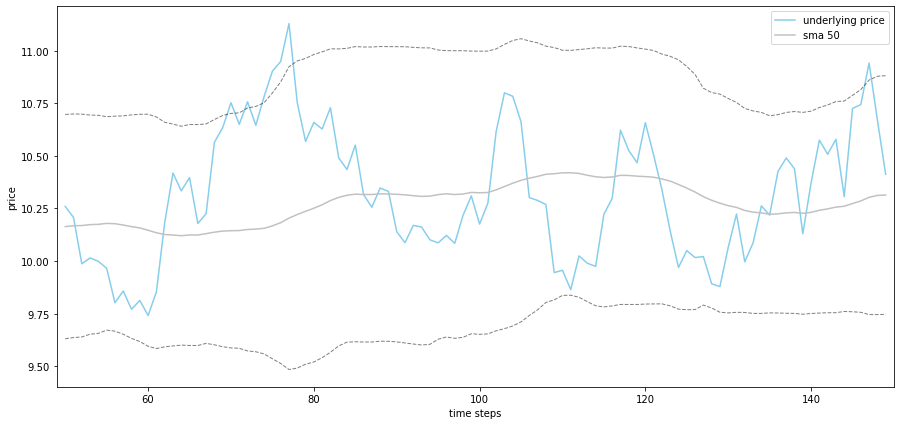

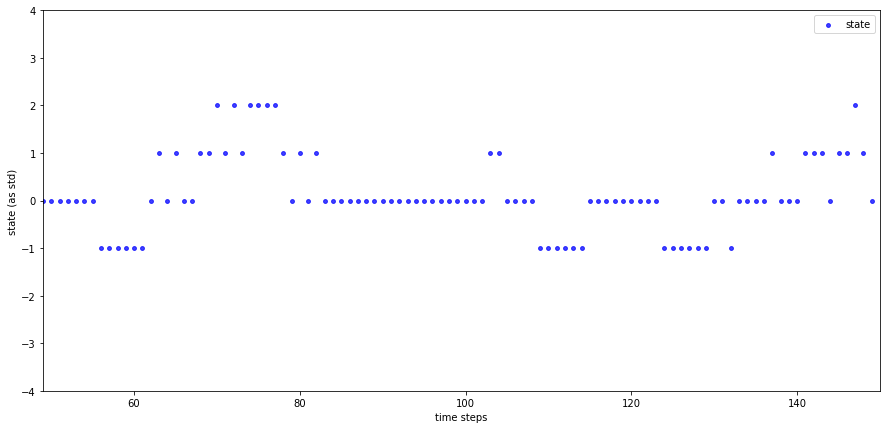

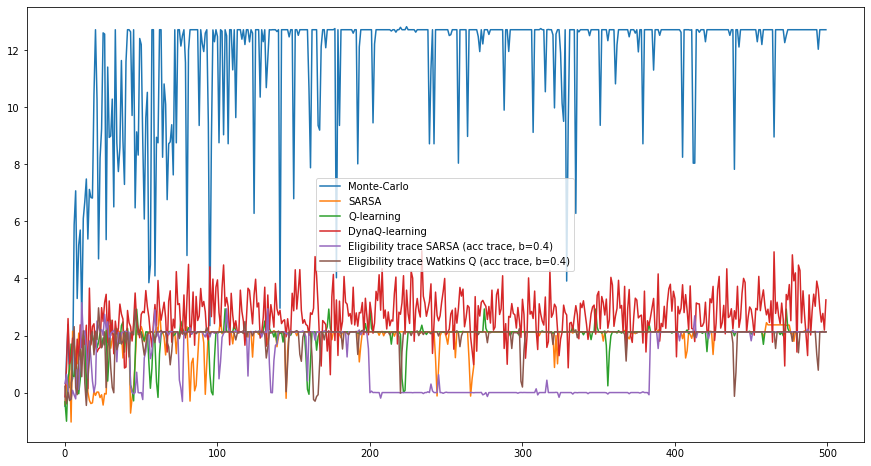

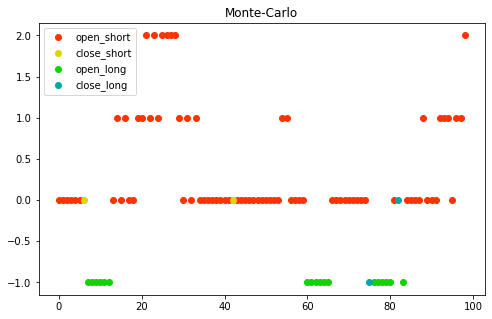

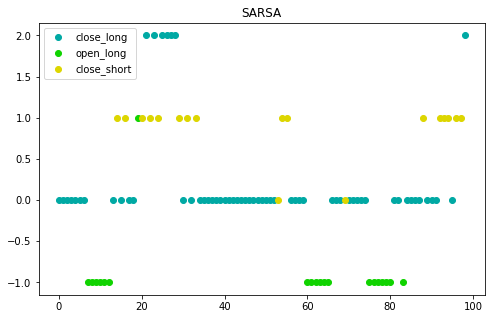

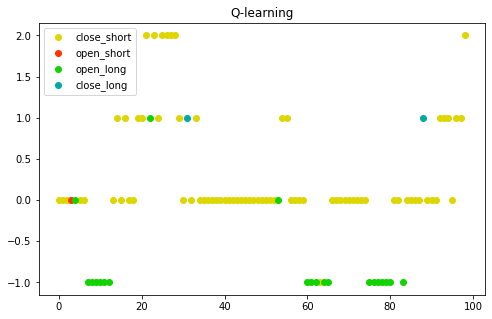

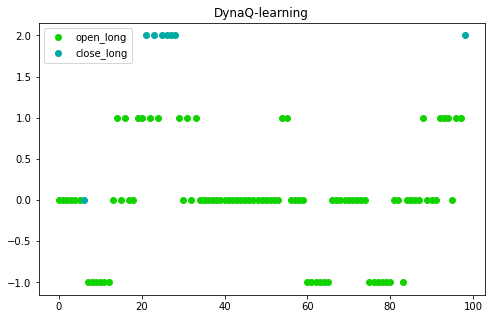

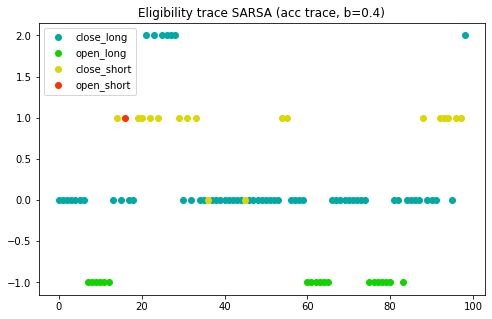

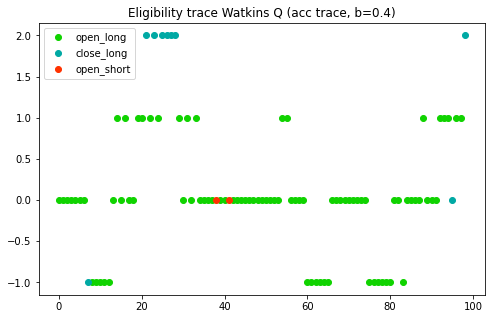

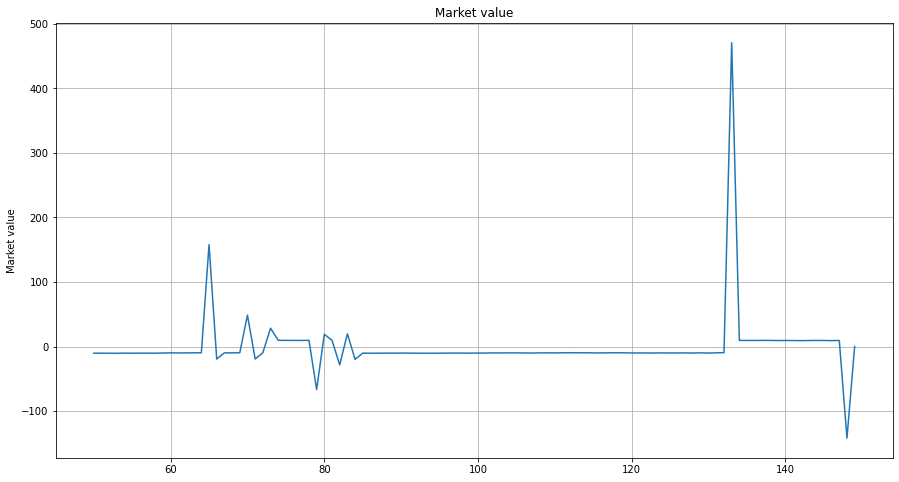

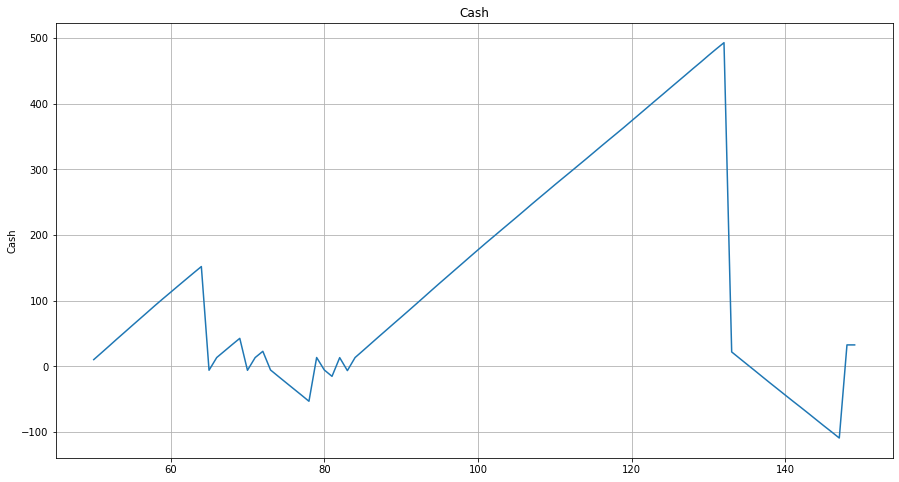

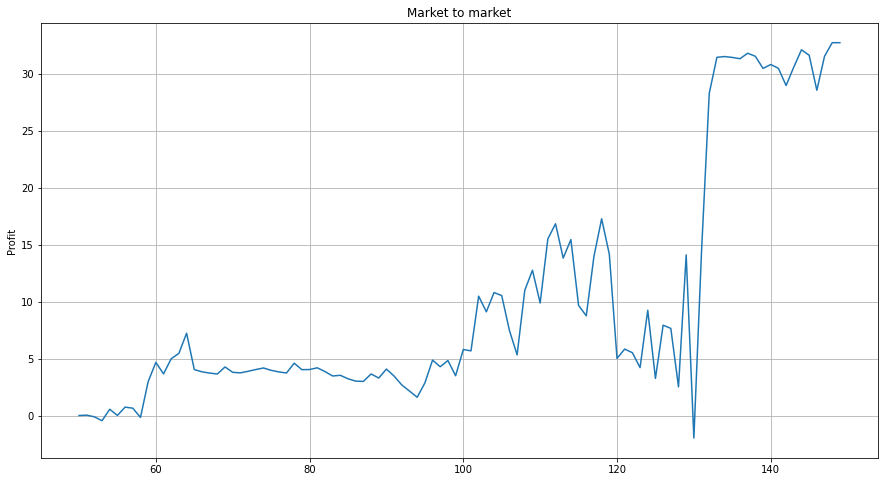

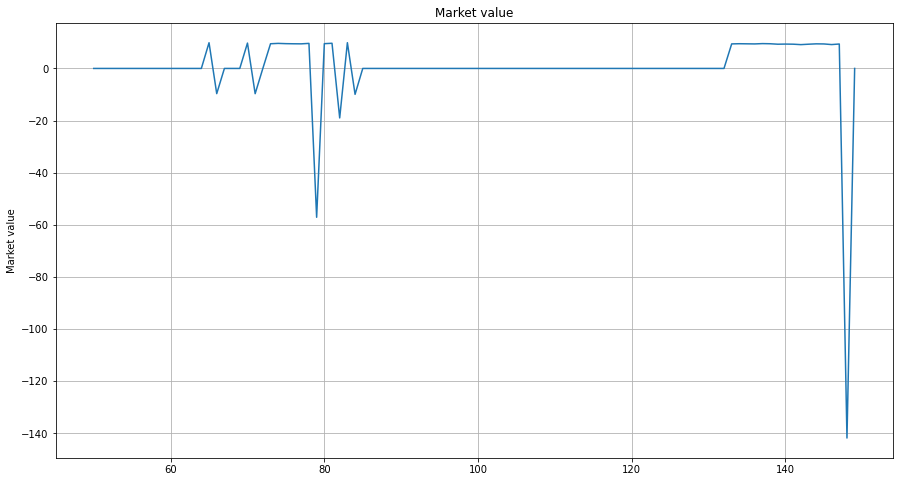

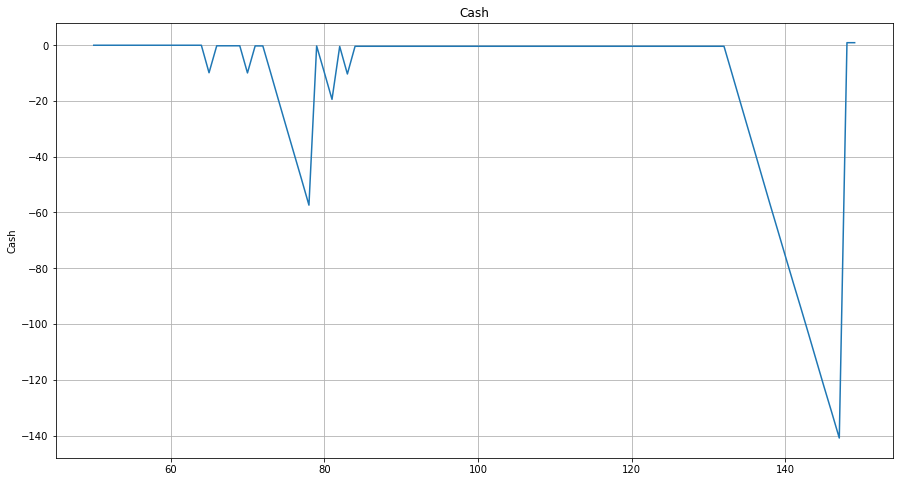

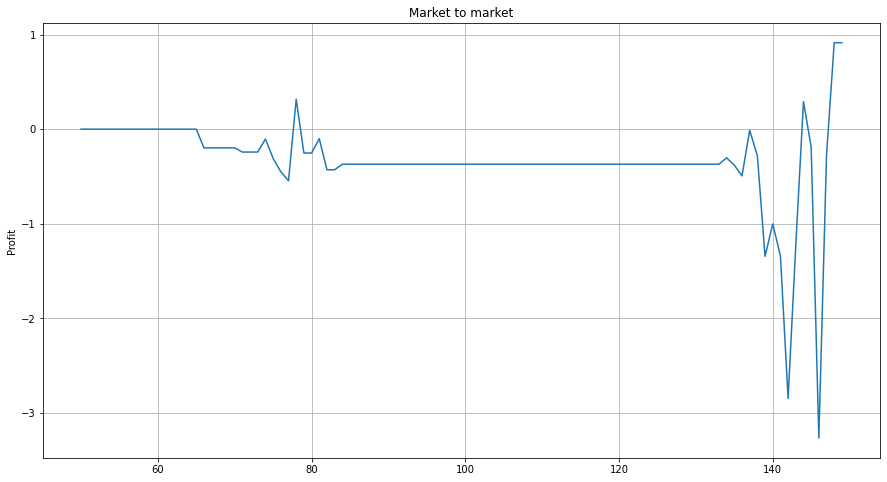

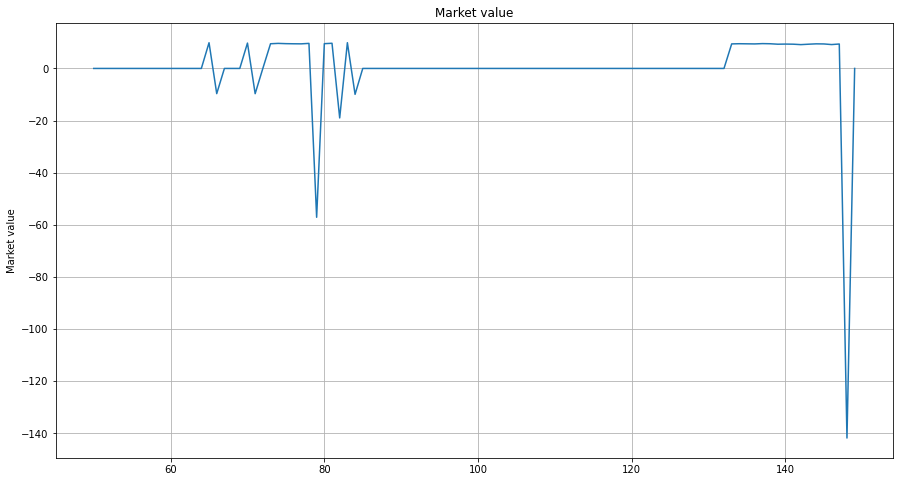

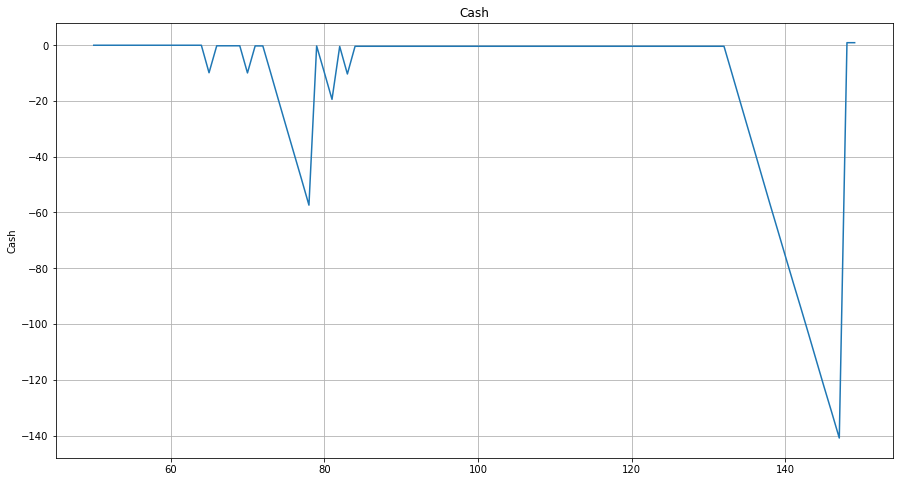

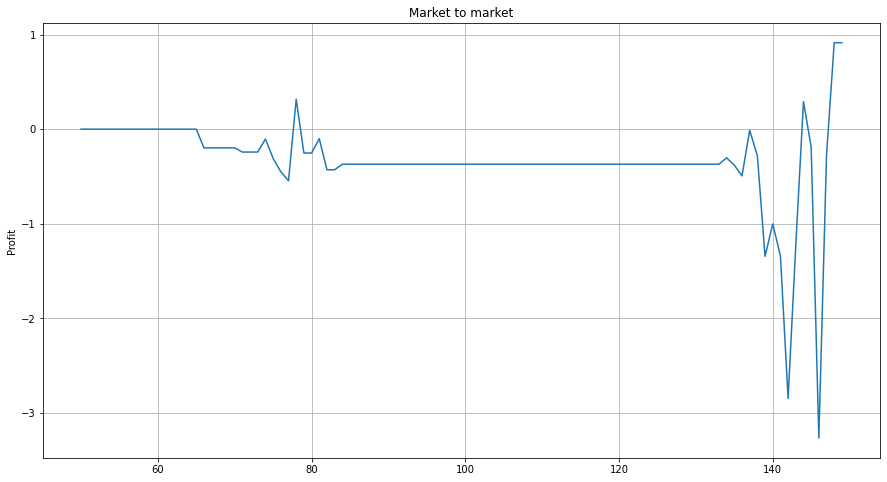

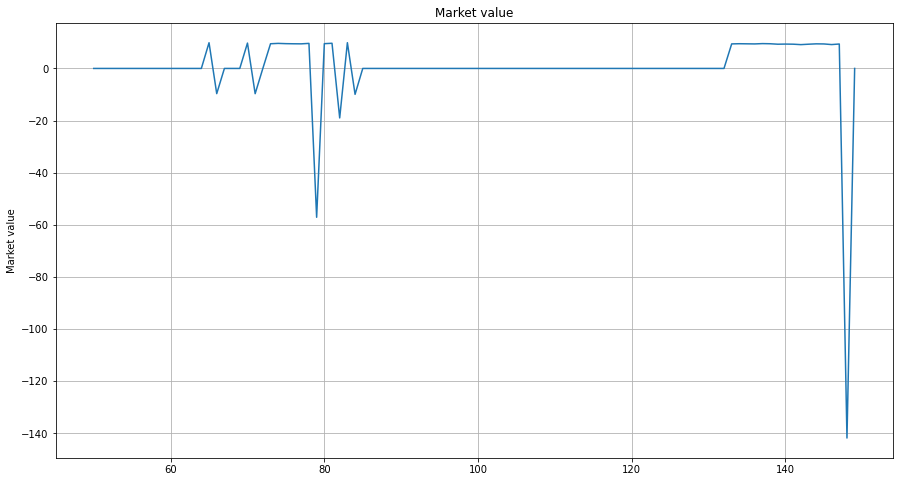

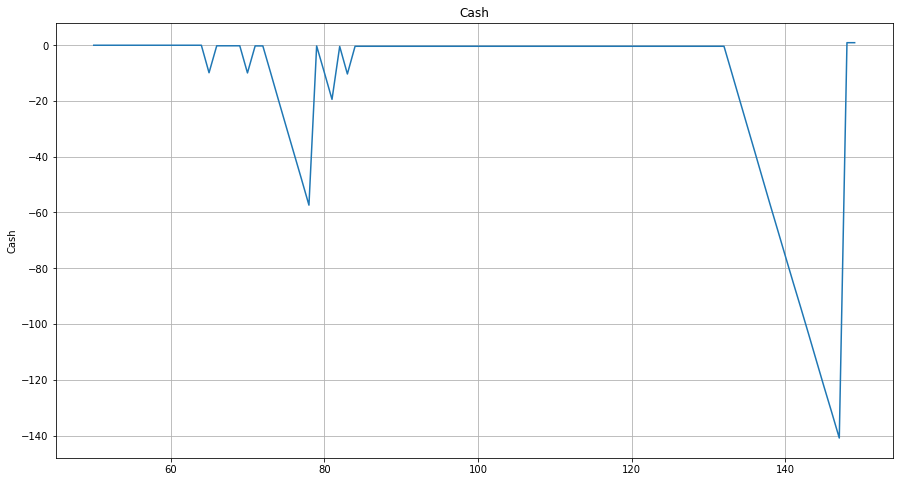

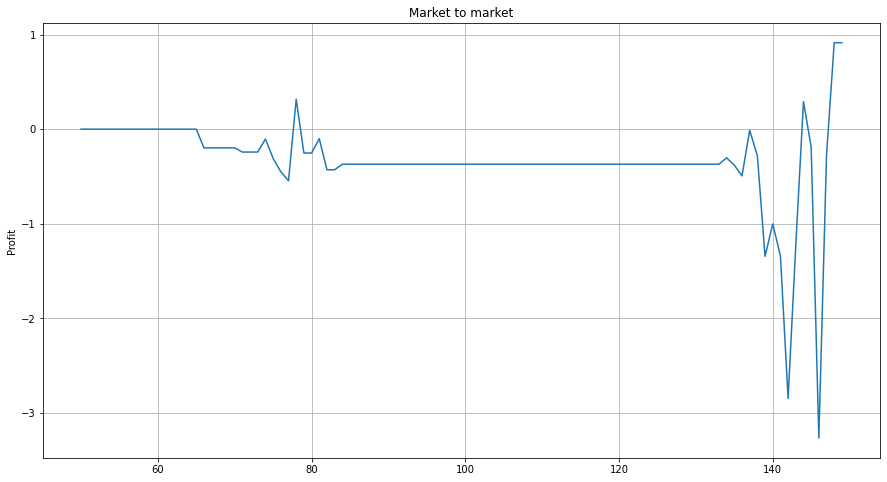

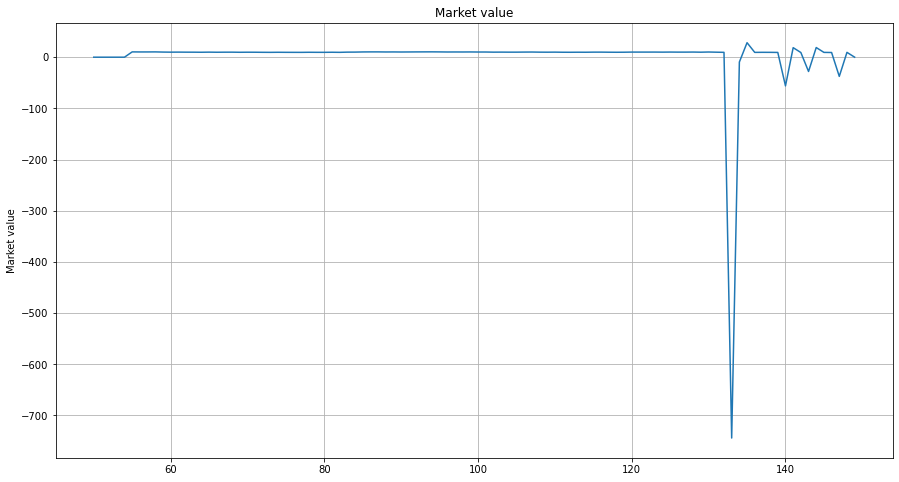

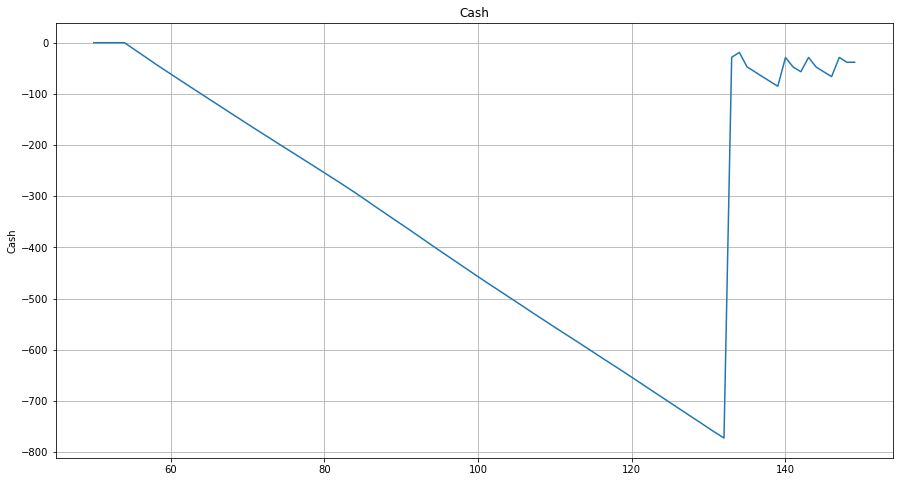

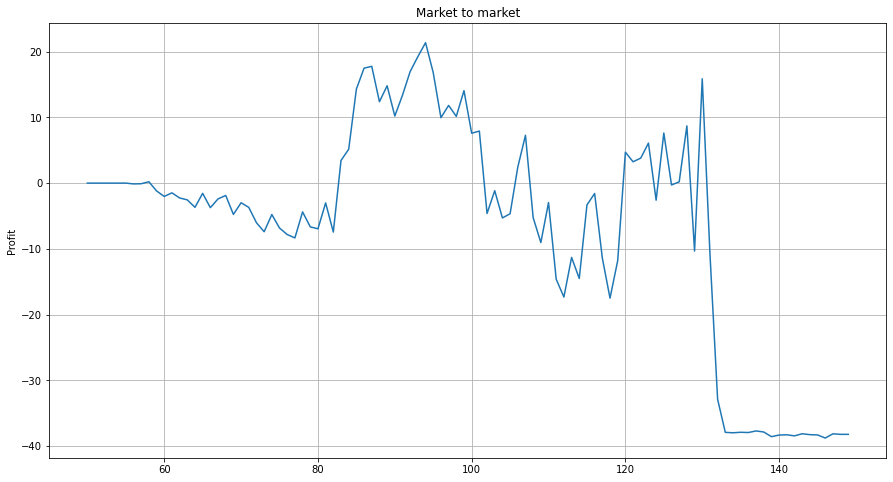

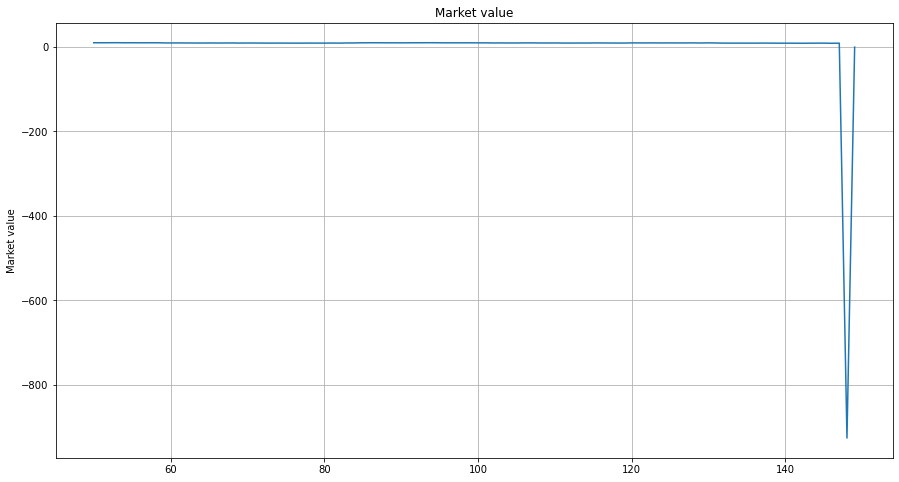

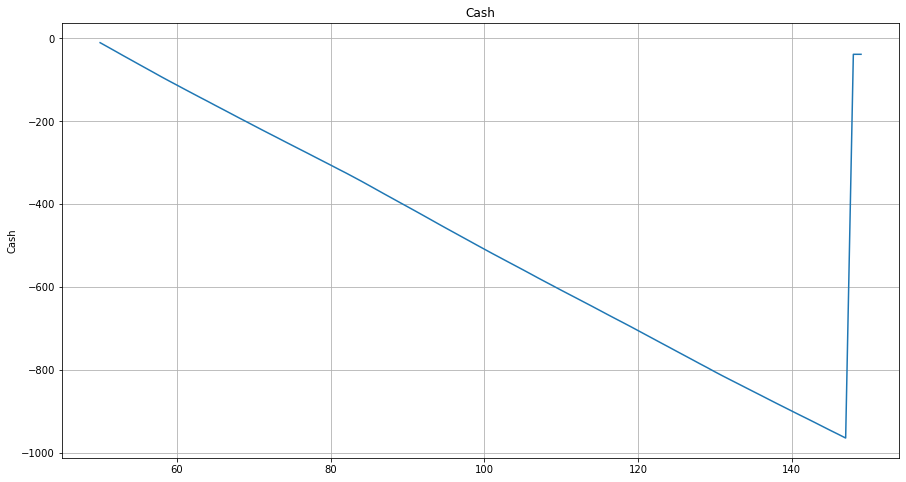

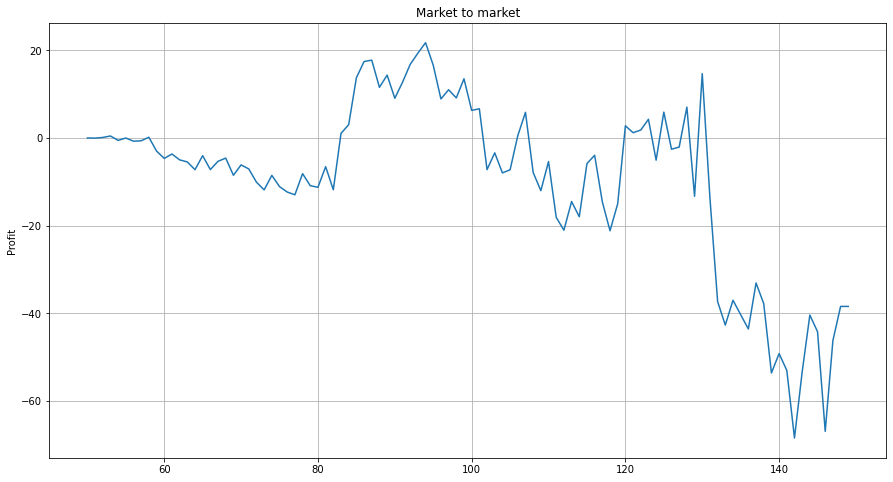

CPU times: total: 2min 24s
Wall time: 2min 25s


(50      0.000000
 51     -0.037431
 52      0.113372
 53      0.450915
 54     -0.551521
          ...    
 145   -44.171475
 146   -66.893750
 147   -46.179476
 148   -38.406146
 149   -38.406146
 Length: 100, dtype: float64,
 50      1
 51      2
 52      3
 53      4
 54      5
        ..
 145    96
 146    97
 147    98
 148     0
 149     0
 Name: position, Length: 100, dtype: int64)

In [16]:
%%time
risk_avertive = False
env = OU_env(sma_window=50, random_state=0, risk_avertive=risk_avertive)
env.render()
episode_n = 500
planning_n = 30
trajectory_len = len(env.states)
gamma = 0.9
alpha = 0.5
beta = 0.4

agent_MC    = RL_agent(env.state_space, list(env.action_space.keys()), risk_avertive=risk_avertive)
agent_SARSA = RL_agent(env.state_space, list(env.action_space.keys()), risk_avertive=risk_avertive)
agent_Q     = RL_agent(env.state_space, list(env.action_space.keys()), risk_avertive=risk_avertive)
agent_ET_S  = RL_agent(env.state_space, list(env.action_space.keys()), risk_avertive=risk_avertive)
agent_ET_Q  = RL_agent(env.state_space, list(env.action_space.keys()), risk_avertive=risk_avertive)
agent_DynQ  = RL_agent(env.state_space, list(env.action_space.keys()), risk_avertive=risk_avertive)

rl_MC    = MonteCarlo(env, agent_MC, episode_n, trajectory_len, gamma)
rl_SARSA = SARSA(env, agent_SARSA, episode_n, trajectory_len, gamma, alpha)
rl_Q     = Q_learning(env, agent_Q, episode_n, trajectory_len, gamma, alpha)
rl_ET_S  = Eligibility_trace_SARSA(env, agent_ET_S, episode_n, trajectory_len, gamma, alpha, beta)
rl_ET_Q  = Eligibility_trace_Q(env, agent_ET_Q, episode_n, trajectory_len, gamma, alpha, beta)
rl_Dyn_Q = Dyna_Q(env, agent_ET_Q, episode_n, trajectory_len, gamma, alpha, planning_n)

rews_MC    = rl_MC.simulate()
rews_SARSA = rl_SARSA.simulate()
rews_Q     = rl_Q.simulate()
rews_ET_S  = rl_ET_S.simulate()
rews_ET_Q  = rl_ET_Q.simulate()
rews_Dyn_Q = rl_Dyn_Q.simulate()

plt.figure(figsize=(15,8))
plt.plot(rews_MC, label='Monte-Carlo')
plt.plot(rews_SARSA, label='SARSA')
plt.plot(rews_Q, label='Q-learning')
plt.plot(rews_Dyn_Q, label='DynaQ-learning')
plt.plot(rews_ET_S, label=f'Eligibility trace SARSA (acc trace, b={beta})')
plt.plot(rews_ET_Q, label=f'Eligibility trace Watkins Q (acc trace, b={beta})')
plt.legend()
plt.show()

colors = {'open_long' : '#10D300', 'open_short' : '#FF3200', 'close_long' : '#00A9A4', 'close_short' : '#DDD600'}

l_traj, perf_rev = rl_MC.get_performance(10)
pd_traj = pd.DataFrame(l_traj)
plt.figure(figsize=(8,5))
for action in pd_traj['actions'].unique():
    plt.scatter(pd_traj[pd_traj['actions']==action].index, pd_traj[pd_traj['actions']==action].states, label=action, c=colors.get(action, 0))
plt.title('Monte-Carlo')
plt.legend()
plt.show()

l_traj, perf_rev = rl_SARSA.get_performance(10)
pd_traj = pd.DataFrame(l_traj)
plt.figure(figsize=(8,5))
for action in pd_traj['actions'].unique():
    plt.scatter(pd_traj[pd_traj['actions']==action].index, pd_traj[pd_traj['actions']==action].states, label=action, c=colors.get(action, 0))
plt.legend()
plt.title('SARSA')
plt.show()

l_traj, perf_rev = rl_Q.get_performance(10)
pd_traj = pd.DataFrame(l_traj)
plt.figure(figsize=(8,5))
for action in pd_traj['actions'].unique():
    plt.scatter(pd_traj[pd_traj['actions']==action].index, pd_traj[pd_traj['actions']==action].states, label=action, c=colors.get(action, 0))
plt.legend()
plt.title('Q-learning')
plt.show()

l_traj, perf_rev = rl_Dyn_Q.get_performance(10)
pd_traj = pd.DataFrame(l_traj)
plt.figure(figsize=(8,5))
for action in pd_traj['actions'].unique():
    plt.scatter(pd_traj[pd_traj['actions']==action].index, pd_traj[pd_traj['actions']==action].states, label=action, c=colors.get(action, 0))
plt.legend()
plt.title('DynaQ-learning')
plt.show()


l_traj, perf_rev = rl_ET_S.get_performance(10)
pd_traj = pd.DataFrame(l_traj)
plt.figure(figsize=(8,5))
for action in pd_traj['actions'].unique():
    plt.scatter(pd_traj[pd_traj['actions']==action].index, pd_traj[pd_traj['actions']==action].states, label=action, c=colors.get(action, 0))
plt.legend()
plt.title(f'Eligibility trace SARSA (acc trace, b={beta})')
plt.show()

l_traj, perf_rev = rl_ET_Q.get_performance(10)
pd_traj = pd.DataFrame(l_traj)
plt.figure(figsize=(8,5))
for action in pd_traj['actions'].unique():
    plt.scatter(pd_traj[pd_traj['actions']==action].index, pd_traj[pd_traj['actions']==action].states, label=action, c=colors.get(action, 0))
plt.legend()
plt.title(f'Eligibility trace Watkins Q (acc trace, b={beta})')
plt.show()

env = OU_env(sma_window=50, random_state=0, risk_avertive=risk_avertive)
back_test(agent_MC, env, cost_bps=0, render=True)
back_test(agent_SARSA, env, cost_bps=0, render=True)
back_test(agent_Q, env, cost_bps=0, render=True)
back_test(agent_ET_S, env, cost_bps=0, render=True)
back_test(agent_ET_Q, env, cost_bps=0, render=True)
back_test(agent_DynQ, env, cost_bps=0, render=True)